## Example 06 - Container Transfer Hub

**Example description:** Example of a container transfer hub, where very large container vessels deliver containers, while smaller vessels take care of the distribution to the hinterland.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

# Used for making the graph to visualize our problem
import networkx as nx

In [2]:
# Create simulation environment
simulation_start = datetime.datetime(2019, 1, 1)

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions

#### Create objects and specify the properties for sites you wish to create

In [3]:
def connect_sites_with_path(data_from_site, data_to_site, data_node, path):
    Nodes = []
    Edges = []
    Site = type('Site', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable,    # Add coordinates to extract distance information and visualize
             core.HasContainer, # Add information on the material available at the site
             core.HasResource), # Add information on serving equipment
    {})                               # The dictionary is empty because the site type is generic

    Node = type('Node', (core.Identifiable, # Give it a name
             core.Log,                      # Allow logging of all discrete events
             core.Locatable),               # Add coordinates to extract distance information and visualize
    {})                                           # The dictionary is empty because the site type is generic
    
    Edge = type('Edge', (core.Identifiable, # Give it a name
             core.Log,           # Allow logging of all discrete events
             core.Locatable,    # Add coordinates to extract distance information and visualize
             core.HasWeather),  # Add water levels to waterways
    {})

    for i, j in enumerate(path):
        if i == 0:
            data_from_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_from_site))

        elif i == len(path) - 1:
            data_to_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_to_site))
            Edges.append([Nodes[i-1], Nodes[i]])
            
        else:
            data_node["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            data_node["name"]='node-' + str(i)
            node = Node(**data_node)
            node.name = node.id
            Nodes.append(node)
            Edges.append([Nodes[i-1], Nodes[i]])
            
    return Nodes, Edges

In [4]:
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Origin locatie",       # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": 10_000_000,         # The capacity of the site
                  "level": 10_000_000}            # The actual volume of the site

data_inter_site = {"env": my_env,                 # The simpy environment defined in the first cel
                "name": "Overslag locatie",       # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 100_000_000,           # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_to_site1 = {"env": my_env,                   # The simpy environment defined in the first cel
                "name": "Haven Nijmegen",         # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 5_000_000,            # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_to_site2 = {"env": my_env,                   # The simpy environment defined in the first cel
                "name": "Haven Deventer",         # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 5_000_000,            # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_node = {"env": my_env,                       # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the waterway
                 "geometry": []}                  # The coordinates of the project site


In [5]:
path_from_to_inter = [[3.223979059949225,52.03276781167011],
                        [3.656045091181079,52.04776907241202],
                        [3.953697524848219,52.02803067898825],
                        [4.067560378249368,51.95173269362142]]

In [6]:
path_inter_to_destination1 = [[4.067560378249368,51.95173269362142],
                             [5.260911,51.820500],
                             [5.830619709457634,51.86183419049677],
                             [5.830727947258836,51.86102575658615]]

In [7]:
path_inter_to_destination2 = [[4.067560378249368,51.95173269362142],
                             [5.937599,51.964640],
                             [6.197050,52.092425],
                             [6.172119444444445,52.247375]]

#### Finally create specific instances of the predefined objects with the specified properties

In [8]:
Nodes1, Edges1 = connect_sites_with_path(data_from_site, data_inter_site, data_node, path_from_to_inter)
Nodes2, Edges2 = connect_sites_with_path(data_inter_site, data_to_site1, data_node, path_inter_to_destination1)
Nodes3, Edges3 = connect_sites_with_path(data_inter_site, data_to_site2, data_node, path_inter_to_destination2)

#### Create graph

Origin locatie
8b7803af-6a8e-11e9-8953-9061aef054a5
8b7803b0-6a8e-11e9-82d2-9061aef054a5
Overslag locatie
Origin locatie - 8b7803af-6a8e-11e9-8953-9061aef054a5
8b7803af-6a8e-11e9-8953-9061aef054a5 - 8b7803b0-6a8e-11e9-82d2-9061aef054a5
8b7803b0-6a8e-11e9-82d2-9061aef054a5 - Overslag locatie
Overslag locatie
8b782966-6a8e-11e9-875b-9061aef054a5
8b782967-6a8e-11e9-8d2d-9061aef054a5
Haven Nijmegen
Overslag locatie - 8b782966-6a8e-11e9-875b-9061aef054a5
8b782966-6a8e-11e9-875b-9061aef054a5 - 8b782967-6a8e-11e9-8d2d-9061aef054a5
8b782967-6a8e-11e9-8d2d-9061aef054a5 - Haven Nijmegen
Overslag locatie
8b783cd2-6a8e-11e9-a01c-9061aef054a5
8b783cd3-6a8e-11e9-a572-9061aef054a5
Haven Deventer
Overslag locatie - 8b783cd2-6a8e-11e9-a01c-9061aef054a5
8b783cd2-6a8e-11e9-a01c-9061aef054a5 - 8b783cd3-6a8e-11e9-a572-9061aef054a5
8b783cd3-6a8e-11e9-a572-9061aef054a5 - Haven Deventer


C:\Users\serva\Documents\Thesis\Modelleren\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



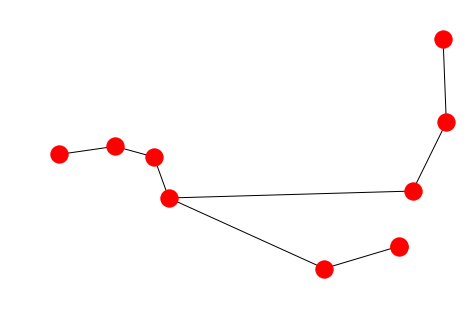

In [9]:
def add_path_to_graph(FG, positions, Nodes, Edges):
    
    for node in Nodes:
        print(node.name)
        positions[node.name] = (node.geometry.x, node.geometry.y)
        FG.add_node(node.name, geometry = node.geometry)
        
    for edge in Edges:
        print(edge[0].name + ' - ' + edge[1].name)
        FG.add_edge(edge[0].name, edge[1].name, weight = 1)
        
    return FG, positions

positions = {}
FG = nx.Graph()

FG, positions = add_path_to_graph(FG, positions, Nodes1, Edges1)
FG, positions = add_path_to_graph(FG, positions, Nodes2, Edges2)
FG, positions = add_path_to_graph(FG, positions, Nodes3, Edges3)

nx.draw(FG, positions)


In [10]:
#Koppelen van water levels aan Edges. Dit lijstje wordt op den duur vervangen door een lijst die uit Sobek moet rollen.
water_levels1 = [1, 2, 3]

#For Nodes1 and Edges1
for i in range(len(Edges1)):
    edge_attribute_dict = {
        (Nodes1[i].name, Nodes1[i+1].name) : {"water level": water_levels1[i]},
        }
    nx.set_edge_attributes(FG, edge_attribute_dict)

print(FG.edges(data=True))

[('Origin locatie', '8b7803af-6a8e-11e9-8953-9061aef054a5', {'weight': 1, 'water level': 1}), ('8b7803af-6a8e-11e9-8953-9061aef054a5', '8b7803b0-6a8e-11e9-82d2-9061aef054a5', {'weight': 1, 'water level': 2}), ('8b7803b0-6a8e-11e9-82d2-9061aef054a5', 'Overslag locatie', {'weight': 1, 'water level': 3}), ('Overslag locatie', '8b782966-6a8e-11e9-875b-9061aef054a5', {'weight': 1}), ('Overslag locatie', '8b783cd2-6a8e-11e9-a01c-9061aef054a5', {'weight': 1}), ('8b782966-6a8e-11e9-875b-9061aef054a5', '8b782967-6a8e-11e9-8d2d-9061aef054a5', {'weight': 1}), ('8b782967-6a8e-11e9-8d2d-9061aef054a5', 'Haven Nijmegen', {'weight': 1}), ('8b783cd2-6a8e-11e9-a01c-9061aef054a5', '8b783cd3-6a8e-11e9-a572-9061aef054a5', {'weight': 1}), ('8b783cd3-6a8e-11e9-a572-9061aef054a5', 'Haven Deventer', {'weight': 1})]


### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - A moving container, so capacity and location
    core.Processor - Allow for loading and unloading
    core.HasResource - Add information on serving equipment
    core.HasDepthRestriction - Add information on depth restriction 

#### First create objects with the desired properties

In [11]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.HasSoil,                   # Add soil object, because it moves soil
                                    core.Routeable,                 # Initialize spill terms
                                    core.HasDepthRestriction),      # Draught (related to loading) is limited by depth
                                   {})

#### Next specify the properties for vessel(s) you wish to create

In [12]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda current_level, desired_level: (desired_level - current_level) / rate

def compute_unloading(rate):
    return lambda current_level, desired_level: (current_level - desired_level) / rate

In [13]:
# Draught of the vessel is dependent on the degree of filling
def draught_vessel(draught_empty, draught_full):
    return lambda x: x * (draught_full - draught_empty) + draught_empty


In [14]:
# Large container vessel variables
data_container_large = {"env": my_env,                              # The simpy environment 
               "name": "Container large",                           # Name
               "geometry": Nodes1[0].geometry,                      # It starts at the "from site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 20_000,                                  # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5),             # Variable speed
               "compute_draught": draught_vessel(1, 2),             # Variable draught of the vessel
               "waves": 0.4,                                        # List of wave heights, where to obtain from?
               "ukc": 0.5}                                          # The required underkeel clearance

In [15]:
# Small container vessel variables
data_container_small_01 = {"env": my_env,                           # The simpy environment 
               "name": "Container small_01",                        # Name
               "geometry": Nodes1[-1].geometry,                     # It starts at the "inter site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 5_000,                                   # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5),             # Variable speed
               "compute_draught": draught_vessel(1, 2),             # Variable draught of the vessel
               "waves": 2.5,                                        # List of wave heights, where to obtain from?
               "ukc": 0.5}                                          # The required underkeel clearance

In [16]:
# Small container vessel variables
data_container_small_02 = {"env": my_env,                           # The simpy environment 
               "name": "Container small_02",                        # Name
               "geometry": Nodes1[-1].geometry,                     # It starts at the "inter site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 5_000,                                   # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5),             # Variable speed
               "compute_draught": draught_vessel(1, 2),             # Variable draught of the vessel
               "waves": 2.5,                                        # List of wave heights, where to obtain from?
               "ukc": 0.5}                                         # The required underkeel clearance

#### Finally create specific instances of the predefined objects with the specified properties

In [17]:
# The simulation object
container_large = TransportProcessingResource(**data_container_large)
container_small_01 = TransportProcessingResource(**data_container_small_01)
container_small_02 = TransportProcessingResource(**data_container_small_02)

### 1.3 Define the activity

In [18]:
# # conditie dat intermediate niet leeg is
# condition = model.LevelCondition(container=intermediate.container, min_level=1)  

# # conditie dat een jaar verstreken is
# stop_condition = modelTimeCondition(…)  
 
# activity_2 = model.Activity(…, 
# start_condition = None,  # laat de activiteit meteen starten als de simulatie begint
# condition = condition,  # steeds als tussendoor de intermediate container leeg is, wacht een uur en check daarna nog eens
# stop_condition = stop_condition)  # de activiteit eindigt als een jaar verstreken is
# (idem voor activity_3)


In [19]:
# Continuous simulation, stop after one year
condition = model.LevelCondition(container=Nodes1[0], min_level=1)
condition_1 = model.LevelCondition(container=Nodes1[-1], min_level=1)
stop_condition = model.TimeCondition(my_env, datetime.datetime(2019, 1, 1), datetime.datetime(2022, 1, 1))



In [20]:
# Create activity
activity_1 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "International transport", # We are moving soil
                          origin = Nodes1[0],               # We originate from the from_site
                          destination = Nodes1[-1],         # And therefore travel to the to_site
                          loader = container_large,         # The benefit of a TSHD, all steps can be done
                          mover = container_large,          # The benefit of a TSHD, all steps can be done
                          unloader = container_large,       # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition,            # Activity runs until Origin is empty
                          stop_condition = stop_condition)            # Stop after 1 year simulation

In [21]:
# Create activity                      
activity_2 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport Nijmegen",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes2[-1],         # And therefore travel to the to_site
                          loader = container_small_01,      # The benefit of a TSHD, all steps can be done
                          mover = container_small_01,       # The benefit of a TSHD, all steps can be done
                          unloader = container_small_01,    # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition_1,          # Activity runs until Intermediate is empty
                          stop_condition = stop_condition)            # Stop after 1 year simulation

In [22]:
# Create activity                      
activity_3 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport Deventer",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes3[-1],         # And therefore travel to the to_site
                          loader = container_small_02,      # The benefit of a TSHD, all steps can be done
                          mover = container_small_02,       # The benefit of a TSHD, all steps can be done
                          unloader = container_small_02,    # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition_1,          # Activity runs until Intermediate is empty
                          stop_condition = stop_condition)            # Stop after 1 year simulation

### 2. Run the simulation

In [23]:
my_env.FG = FG
my_env.run()

print("\n*** Transportation of containers finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))


Time = 2019-01-01 00:00
Start condition is satisfied, International transport transporting from Origin locatie to Overslag locatie started.

Time = 2019-01-01 00:00
Start condition is satisfied, Hinterland transport Nijmegen transporting from Overslag locatie to Haven Nijmegen started.

Time = 2019-01-01 00:00
Start condition is satisfied, Hinterland transport Deventer transporting from Overslag locatie to Haven Deventer started.
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothi

Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing 

Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing 

Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing 

Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing 

Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing 

Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move
Nothing to move

Time = 2022-01-01 00:09
Stop condition is satisfied, International transport transporting from Origin locatie to Overslag locatie completed.

Time = 2022-01-01 00:31
Stop condition is satisfied, Hinterland transport Nijmegen transporting from Overslag locatie to 

### 3. Postprocessing

In [24]:
vessels = [container_large, container_small_01, container_small_02]
# print(vessels)

# import pandas as pd
# df = pd.DataFrame.from_dict(vessels[0].log)
# df

In [25]:
Nodes1[0].container.level

0.0

In [26]:
Nodes1[-1].container.level

0.0

In [27]:
for j in Nodes2[-1].log['Value']:
    while Nodes2[-1].log['Value'][j] < Nodes2[-1].container.capacity:
        j = j + 1
    else:
        print('Capacity of Nijmegen port is reached on', Nodes2[-1].log['Timestamp'][j])
        print('Capacity of Nijmegen port is reached after', Nodes2[-1].log['Timestamp'][j] - (datetime.datetime(1970, 1, 1, 1, 0, 0) + datetime.timedelta(seconds=my_env.epoch)))
        break

Capacity of Nijmegen port is reached on 2020-11-18 02:31:25.060783
Capacity of Nijmegen port is reached after 687 days, 2:31:25.060783


In [28]:
for j in Nodes3[-1].log['Value']:
    while Nodes3[-1].log['Value'][j] < Nodes2[-1].container.capacity:
        j = j + 1
    else:
        print('Capacity of Deventer port is reached on', Nodes3[-1].log['Timestamp'][j])
        print('Capacity of Deventer port is reached after', Nodes3[-1].log['Timestamp'][j] - (datetime.datetime(1970, 1, 1, 1, 0, 0) + datetime.timedelta(seconds=my_env.epoch)))
        break

Capacity of Deventer port is reached on 2021-06-26 16:36:52.711610
Capacity of Deventer port is reached after 907 days, 16:36:52.711610


#### Vessel planning

In [29]:
activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### KML visualisation

In [30]:
plot.vessel_kml(my_env, vessels, stepsize = 10000)

In [31]:
plot.site_kml(my_env, [Nodes1[0], Nodes1[-1], Nodes2[-1], Nodes3[-1]], stepsize = 10000)

In [32]:
#Open the file
if platform.system():
    !start ./vessel_movements.kml
    !start ./site_development.kml
else:
    !start explorer ./vessel_movements.kml
    !start explorer ./site_development.kml

In [33]:
# Properties toewijzen aan Edges
# for edge in FG.edges(data = True):
#     print(edge)

In [34]:
# vessels[0].compute_draught

In [35]:
# a = Nodes3[-1].log['Timestamp'][j]
# import pytz
# b = datetime.datetime(1970, 1, 1, 1, 0, 0) + datetime.timedelta(seconds=my_env.epoch)
# print(a)
# print(b)
# print(a-b)